# Sentiment Analysis 2.0

Richard Yang

After determining our sentiment analysis model and its pipeline, we can further prepare to answer the following questions:

- Identify top reasons for successful data science / AI initiatives (sentiment analysis) - these can be related to technology maturity, people, data availability, etc.
    - Suggest why certain types of applications succeed vs other fail
    - Plot a timeline to illustrate how the sentiment is changing over time
- Identify new technologies and AI solutions that might be affecting the landscape of data science applications
    - Plot a timeline to illustrate the introduction of some of these technologies
- Demonstrate what companies, academic institutions and government entities can do to accelerate the development of these transformative capabilities
- Leverage appropriate NLP techniques to identify organizations, people and locations, then apply targeted sentiment
    - What types of companies (based on the lines of business) should invest in data science initiatives today or near future (success stories)?
        - Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
    - What types of applications cannot currently be transformed by AI, based on today's state of technology (failures)?
        - Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import pandas as pd
import nltk
import spacy
from spacy import displacy
import ast
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import regex as re
# import chain from itertools
from itertools import chain

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# display maximum width of columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

2023-05-25 08:25:13.611386: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 08:25:13.660969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 08:25:14.848209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorfl

In [6]:
# import spacy.cli
# spacy.cli.download('en_core_web_lg')

In [2]:
df_rawfilter = pd.read_parquet('filtered.parquet', engine='pyarrow')

In [4]:
AI_word_list = [
    '[Aa]rtificial [Ii]ntelligence[s]?',
    'AI',
    '[Cc]hatGPT',
    '[Cc]hatbot[s]?',
    '[Cc]hat [Bb]ot[s]?',
    'GPT',
    'LLM[s]?',
    '[Ll]arge [Ll]anguage [Mm]odel[s]?',
    '[Mm]achine [Ll]earning',
    '[Dd]eep [Ll]earning',
    '[Nn]eural [Nn]etwork[s]?',
    '[Nn]atural [Ll]anguage [Pp]rocessing'
    '[Nn]atural [Ll]anguage',
    'NLP',
    'Robotic[s]?',
    '[Rr]obotic [Pp]rocess [Aa]utomation[s]?',
    '[Dd]ata [Ss]cience[s]?',
    '[Dd]ata [Aa]nalytics',
    '[Pp]redictive [Aa]nalytics',
    '[Cc]omputer [Vv]ision',
    '[Ii]mage [Rr]ecognition[s]?',
    '[Ff]acial [Rr]ecognition[s]?',
    '[Vv]oice [Rr]ecognitionp[s]?',
    '[Aa]ugmented [Rr]eality[s]?',
    '[Vv]irtual [Rr]eality[s]?',
    '[Aa]utonomous [Vv]ehicle[s]?',
]

In [8]:
%%time
# define a function to filter the rows that are related to the AI topic
def filter_AI(text):

    for pattern in AI_word_list:
        if re.search(pattern, text):
            return True
    return False

# apply the filter_AI function to df
df_rawfilter['AI_keyword_related'] = df_rawfilter['clean_text'].apply(lambda x: filter_AI(x))

df_rawfilter['AI_keyword_related'].value_counts()

CPU times: user 3.03 s, sys: 0 ns, total: 3.03 s
Wall time: 3.05 s


True     153602
False       355
Name: AI_keyword_related, dtype: int64

In [9]:
df_AIkeywords = df_rawfilter[df_rawfilter['AI_keyword_related'] == True]
df_AIkeywords.shape

(153602, 8)

In [11]:
# delete the columns that are not needed: language, text, AI_related
df_AIkeywords.drop(['language', 'text', 'AI_related','AI_keyword_related'], axis=1, inplace=True)
# print column names
print(df_AIkeywords.columns)

Index(['url', 'date', 'title', 'clean_text'], dtype='object')


### Sentence Segmentation

Since none of the sentiment analysis model can have a good performance on the whole news text data, I will apply sentiment analysis based on sentences

The sentences that will be analyzed contains keywords that are more closely related with AI technologies. From **153602** articles, I successfully extracted **1,164,823** sentences which will be our main target in this sentiment analysis section

In [15]:
%%time
import spacy
import pandas as pd
from multiprocessing import Pool

# # Load the spaCy model
# nlp = spacy.load('en_core_web_lg')

# Function to process a single row and find sentences containing keywords
def process_row(row, keyword_list):
    sentences = []

    # Process the text using spaCy
    doc = nlp(row['clean_text'])

    # Loop through the sentences in the processed text
    for sentence in doc.sents:
        # Check if any of the keywords are present in the sentence
        detected_keywords = [keyword for keyword in keyword_list if keyword in sentence.text]
        if detected_keywords:
            # Append the sentence to the list
            sentences.append({
                'url': row['url'],
                'title': row['title'],
                'date': row['date'],
                'sentence': sentence.text,
                'keyword': ', '.join(detected_keywords)
            })

    return sentences

# Function to find the sentences that contain the keywords using multiprocessing
def find_sentences_parallel(df, keyword_list):
    # Create a multiprocessing pool
    pool = Pool()

    # Process each row in parallel
    results = pool.starmap(process_row, [(row, keyword_list) for _, row in df.iterrows()])
    pool.close()
    pool.join()

    # Flatten the results
    sentences = [sentence for row_result in results for sentence in row_result]

    # Create a dataframe from the list of sentences
    df_sentences = pd.DataFrame(sentences)

    return df_sentences

# Find the sentences that contain the keywords using multiprocessing
df_sentences = find_sentences_parallel(df_AIkeywords, AI_word_list)


CPU times: user 22.8 s, sys: 2.96 s, total: 25.8 s
Wall time: 1h 21min 44s


In [3]:
# store the dataframe in a csv file
# df_sentences.to_csv('sentences.csv', index=False)
# df_sentences.to_parquet('sentences.parquet', engine='pyarrow')
df_sentences = pd.read_parquet('sentences.parquet', engine='pyarrow')

In [ ]:
df_sentences.shape

(1164823, 5)

In [ ]:
df_sentences.head(2)

,url,title,date,sentence,keyword
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,2021-03-18,"(People’s Daily Online,Thanks to the application of an artificial intelligence (AI)-empowered roadside electronic toll collection (ETC) system, China’s capital city Beijing has seen significant improvement in the efficiency of parking fee collection, turnover of roadside parking spots, order in roadside parking, as well as traffic congestion.",AI
1,http://en.people.cn/n3/2021/0318/c90000-9830122.html,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,2021-03-18,",With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they drive away.,“This road used to be full of cars, and even the normal lanes were occupied.",AI


### Identify new technologies and AI solutions that might be affecting the landscape of data science applications
#### Plot a timeline to illustrate the introduction of some of these technologies

In this section, I did the following steps:
1. created a new AI word list where contains some of the hot keywords that were extracted from the topic modelling.

2. extracted the sentences that contains these keywords, and append a **'extracted_keyword'** list for every row

3. created a new dataframe that contains the **'date'** and **'extracted_keyword'** columns

4. find the earliest date for every keyword, and append a **'earliest_date'** list for every row

5. generate a plot to show the earlist date when the technology is mentioned for the first time.


In [ ]:
AI_word_list = [
'[Gg][Pp][Tt]-3',
'[Aa]lpha[Ff]old',
'[Dd][Aa][Ll]{2}·[Ee]',
'[Tt]ransformers',
'[Mm]eta-[Ll]earning',
'[Ff]ederated [Ll]earning',
'[Ss]ynthetic [Dd]ata [Gg]eneration',
'[Ee]xplainable [Aa][Ii]',
'[Qq]uantum [Mm]achine [Ll]earning',
'[Gg]enerative [Aa]dversarial [Nn]etworks', 
'GANs',
'[Ee]dge [Aa][Ii]',
'[Aa]utonomous [Rr]obotics',
'[Rr]einforcement [Ll]earning',
'[Tt]ransfer [Ll]earning',
'[Nn]atural [Ll]anguage [Uu]nderstanding',
'[Nn][Ll][Uu]',
'[Oo]pen[Aa][Ii]',
'[Gg][Pp][Tt]-4',
'[Mm]ulti-[Tt]ask [Ll]earning',
'[Aa]daptive [Ll]earning [Ss]ystems',
'[Nn]eural [Aa]rchitecture [Ss]earch',
'[Mm]odel [Cc]ompression',
'[Ss]elf-[Ss]upervised [Vv]ision [Mm]odels',
'[Cc]ontinual [Rr]einforcement [Ll]earning',
'[Uu]nsupervised [Ll]earning',
'[Dd]eep [Rr]einforcement [Ll]earning',
'[Nn]eurosymbolic [Aa][Ii]',
'[Dd]ifferentiable [Pp]rogramming',
'[Hh]ybrid [Aa][Ii]',
'[Rr]obotics [Pp]rocess [Aa]utomation', 
'RPA',
'[Pp]rivacy-[Pp]reserving',
'[Aa]utomatic [Ss]peech [Rr]ecognition',
'ASR',
'[Kk]nowledge [Dd]istillation',
'[Rr]obotics [Pp]erception',
'[Dd]omain [Aa]daptation',
'[Tt]ransformer-Based [Rr]ecommender [Ss]ystems',
'[Cc]ausal [Ii]nference',
'[Nn]euroevolution',
'[Aa][Ii] for [Cc]ybersecurity'
]

word_mapping = {
    '[Gg][Pp][Tt]-3': 'gpt-3',
    '[Aa]lpha[Ff]old': 'alphafold',
    '[Dd][Aa][Ll]{2}·[Ee]': 'dalle',
    '[Tt]ransformers': 'transformers',
    '[Mm]eta-[Ll]earning': 'meta-learning',
    '[Ff]ederated [Ll]earning': 'federated learning',
    '[Ss]ynthetic [Dd]ata [Gg]eneration': 'synthetic data generation',
    '[Ee]xplainable [Aa][Ii]': 'explainable ai',
    '[Qq]uantum [Mm]achine [Ll]earning': 'quantum machine learning',
    '[Gg]enerative [Aa]dversarial [Nn]etworks': 'generative adversarial networks',
    'GANs': 'gans',
    '[Ee]dge [Aa][Ii]': 'edge ai',
    '[Aa]utonomous [Rr]obotics': 'autonomous robotics',
    '[Rr]einforcement [Ll]earning': 'reinforcement learning',
    '[Tt]ransfer [Ll]earning': 'transfer learning',
    '[Nn]atural [Ll]anguage [Uu]nderstanding': 'natural language understanding',
    '[Nn][Ll][Uu]': 'nlu',
    '[Oo]pen[Aa][Ii]': 'openai',
    '[Gg][Pp][Tt]-4': 'gpt-4',
    '[Mm]ulti-[Tt]ask [Ll]earning': 'multi-task learning',
    '[Aa]daptive [Ll]earning [Ss]ystems': 'adaptive learning systems',
    '[Nn]eural [Aa]rchitecture [Ss]earch': 'neural architecture search',
    '[Mm]odel [Cc]ompression': 'model compression',
    '[Ss]elf-[Ss]upervised [Vv]ision [Mm]odels': 'self-supervised vision models',
    '[Cc]ontinual [Rr]einforcement [Ll]earning': 'continual reinforcement learning',
    '[Uu]nsupervised [Ll]earning': 'unsupervised learning',
    '[Dd]eep [Rr]einforcement [Ll]earning': 'deep reinforcement learning',
    '[Nn]eurosymbolic [Aa][Ii]': 'neurosymbolic ai',
    '[Dd]ifferentiable [Pp]rogramming': 'differentiable programming',
    '[Hh]ybrid [Aa][Ii]': 'hybrid ai',
    '[Rr]obotics [Pp]rocess [Aa]utomation': 'robotics process automation',
    'RPA': 'rpa',
    '[Pp]rivacy-[Pp]reserving': 'privacy-preserving',
    '[Aa]utomatic [Ss]peech [Rr]ecognition': 'automatic speech recognition',
    'ASR': 'asr',
    '[Kk]nowledge [Dd]istillation': 'knowledge distillation',
    '[Rr]obotics [Pp]erception': 'robotics perception',
    '[Dd]omain [Aa]daptation': 'domain adaptation',
    '[Cc]ausal [Ii]nference': 'causal inference',
    '[Nn]euroevolution': 'neuroevolution',
    '[Aa][Ii] for [Cc]ybersecurity': 'ai for cybersecurity'
}
import re
def extract_keywords(sentence, keyword_list, word_mapping):
    keywords = []
    for keyword in keyword_list:
        pattern = re.compile(keyword, re.IGNORECASE)
        if re.search(pattern, sentence):
            simplified_keyword = word_mapping[keyword]
            keywords.append(simplified_keyword)
    return ', '.join(keywords)

# Apply the function to extract keywords and store them in a new column 'extracted_keywords'
df_sentences['extracted_keywords'] = df_sentences['sentence'].apply(lambda x: extract_keywords(x, AI_word_list, word_mapping))
df_sentences['extracted_keywords'] = df_sentences['extracted_keywords'].apply(lambda x: [x] if x else [])


In [29]:
df_filtered = df_sentences[df_sentences['extracted_keywords'].apply(lambda x: len(x) > 0)]
df_filtered.shape

(104070, 9)

In [ ]:
# Create a new DataFrame with 'date' and 'extracted_keywords' columns
df_filtered = df_sentences[['date', 'extracted_keywords']].copy()

# Convert the 'extracted_keywords' column to tuples of (date, extracted_keywords)
df_filtered['key'] = df_filtered.apply(lambda row: (row['date'], tuple(row['extracted_keywords'])), axis=1)

# Remove duplicate rows based on the 'key' column
df_filtered.drop_duplicates(subset='key', inplace=True)

# Select 'date' and 'extracted_keywords' columns and drop the 'key' column
df_filtered = df_filtered[['date', 'extracted_keywords']]

# Sort the DataFrame by date in ascending order
df_filtered.sort_values(by='date', inplace=True)

# Reset the index of the DataFrame
df_filtered.reset_index(drop=True, inplace=True)

# Split the string values into a list of keywords
df_filtered['extracted_keywords'] = df_filtered['extracted_keywords'].apply(lambda x: x[0].split(', ') if isinstance(x, list) and len(x) > 0 else [])
df_filtered = df_filtered[df_filtered['extracted_keywords'].apply(lambda x: len(x) > 0)]



In [52]:
import pandas as pd

# Create a copy of df_filtered
new_df = df_filtered.copy()

# Split the string values into a list of keywords
new_df['extracted_keywords'] = new_df['extracted_keywords'].apply(lambda x: x[0].split(', ') if isinstance(x, list) and len(x) > 0 else [])

# Display the updated DataFrame
print(new_df)


             date                                      extracted_keywords
0      2020-01-01                               [ai, facial recognitions]
1      2020-01-01                                     [ai, deep learning]
2      2020-01-01                                                    [ai]
3      2020-01-01                                   [ai, computer vision]
4      2020-01-01  [ai, machine learning, deep learning, computer vision]
...           ...                                                     ...
33144  2023-04-28                           [chatgpt, gpt, deep learning]
33145  2023-04-28                            [ai, llms, machine learning]
33146  2023-04-28                                     [ai, chatbots, gpt]
33147  2023-04-28     [ai, llms, large language models, machine learning]
33148  2023-04-28             [ai, robotics, robotic process automations]

[33149 rows x 2 columns]


In [41]:
# Generate a simplified version of list of keywords
simplified_list = [value for key, value in word_mapping.items()]

In [56]:
import pandas as pd
import numpy as np

# Create a dictionary to store the earliest occurrence time for each keyword
earliest_dates = {}

# Iterate over each keyword in simplified_list
for keyword in simplified_list:
    earliest_date = np.datetime64('NaT')  # Initialize earliest_date to NaT
    
    # Iterate over each row in df_sentences
    for _, row in df_filtered.iterrows():
        date = row['date']
        extracted_keywords = row['extracted_keywords']
        
        # Check if the keyword is in the extracted_keywords list
        if keyword in extracted_keywords:
            # Update the earliest_date if it is earlier than the current earliest_date
            if pd.isnull(earliest_date) or date < earliest_date:
                earliest_date = date
    
    # Store the earliest_date for the keyword in the dictionary
    earliest_dates[keyword] = earliest_date

# Create a DataFrame from the earliest_dates dictionary
df_earliest_dates = pd.DataFrame(list(earliest_dates.items()), columns=['Keyword', 'Earliest Date'])
df_earliest_dates = df_earliest_dates.sort_values('Earliest Date')

# Display the DataFrame
print(df_earliest_dates)


                             Keyword Earliest Date
31                               rpa    2020-01-01
11                           edge ai    2020-01-01
13            reinforcement learning    2020-01-02
3                       transformers    2020-01-02
5                 federated learning    2020-01-02
10                              gans    2020-01-02
9    generative adversarial networks    2020-01-02
16                               nlu    2020-01-03
7                     explainable ai    2020-01-03
29                         hybrid ai    2020-01-05
17                            openai    2020-01-09
6          synthetic data generation    2020-01-14
15    natural language understanding    2020-01-15
40              ai for cybersecurity    2020-01-15
34                               asr    2020-01-21
25             unsupervised learning    2020-01-28
14                 transfer learning    2020-01-30
33      automatic speech recognition    2020-01-30
4                      meta-lea

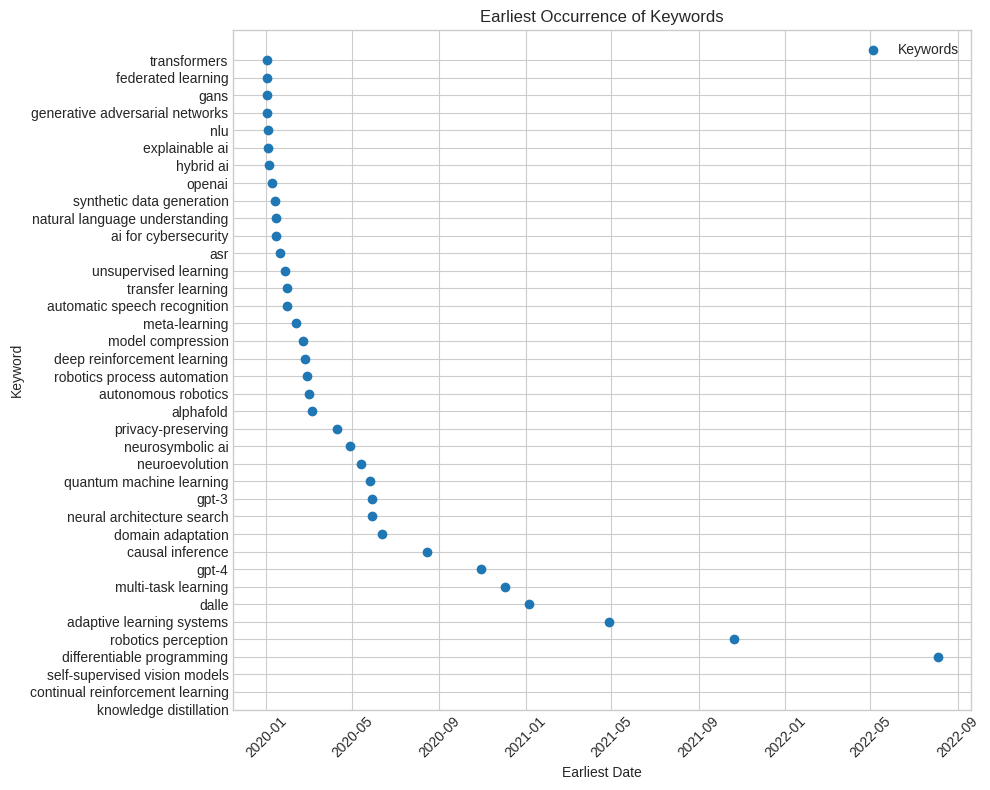

In [73]:
import matplotlib.pyplot as plt

# Set larger figure size
plt.figure(figsize=(10, 8))  # Adjust width and height as desired

# Assign numerical values as y-coordinate for each keyword
y_values = range(len(df_earliest_dates))

# Plotting
plt.scatter(df_earliest_dates['Earliest Date'], y_values, marker='o')

# Draw lines from the left to each dot
for y, date in zip(y_values, df_earliest_dates['Earliest Date']):
    plt.hlines(y, xmin=min(df_earliest_dates['Earliest Date']), xmax=date, colors='blue', linestyles='dashed')

# Customize plot appearance
plt.xlabel('Earliest Date')
plt.ylabel('Keyword')
plt.title('Earliest Occurrence of Keywords')
plt.yticks(y_values, df_earliest_dates['Keyword'])
plt.xticks(rotation=45)
plt.grid(True)

# Add additional styling
plt.tight_layout()  # Improves spacing between elements
plt.style.use('seaborn-whitegrid')  # Apply a predefined style
plt.legend(['Keywords'])  # Add a legend

# Show the plot
plt.show()


## Identify top reasons for successful data science / AI initiatives (sentiment analysis) - these can be related to technology maturity, people, data availability, etc.

In this part, we will use the sentiment analysis technique to identify the top reasons for successful data science / AI initiatives. We will also plot a timeline to illustrate how the sentiment is changing over time.

After investigating the models, I found that we can use Yelp Sentiment Analysis model with a combination of Yelp Sentiment Analysis model and Pre-trianed NewsSentiment 1.1.25 which are trained and fine-tuned on news data



#### Generate Sentiment Columns

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer
model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")

In [ ]:
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True
)


## Read the Sentence data

In [ ]:
# Read only the 'title' column from the parquet file
import pandas as pd
df_sentences = pd.read_parquet('sentences.parquet')
df_sentences_sentiment = df_sentences.copy()

In [ ]:
from transformers import pipeline

# Function to analyze sentiment for a given sentence
def analyze_sentiment(sentence):
    max_length = 512
    if len(sentence) > max_length:
        # Truncate long sentences to the maximum length
        sentence = sentence[:max_length]
    result = sentiment_analysis(sentence)
    return result

# Apply sentiment analysis to the 'sentence' column in the DataFrame
df_sentences_sentiment['sentiment'] = df_sentences_sentiment['sentence'].apply(analyze_sentiment)


In [ ]:
# Define a lambda function to calculate prob_pos and prob_neg
def calculate_prob(row):
    sentiment_list = row
    prob_pos = None
    prob_neg = None

    if isinstance(sentiment_list, list) and len(sentiment_list) > 0:
        sentiment_dict = sentiment_list[0]
        positive_score = None
        neutral_score = None
        negative_score = None

        for sentiment in sentiment_dict:
            if sentiment['label'] == 'positive':
                positive_score = sentiment['score']
            elif sentiment['label'] == 'neutral':
                neutral_score = sentiment['score']
            elif sentiment['label'] == 'negative':
                negative_score = sentiment['score']
        
        if positive_score is not None and neutral_score is not None:
            prob_pos = positive_score + (neutral_score / 2)
        
        if negative_score is not None and neutral_score is not None:
            prob_neg = negative_score + (neutral_score / 2)

    return (prob_pos, prob_neg)

# Apply the lambda function to create new columns
df_sentences_sentiment[['prob_pos', 'prob_neg']] = df_sentences_sentiment['sentiment'].apply(calculate_prob).apply(pd.Series)

# Display the updated DataFrame
print(df_sentences_sentiment.head())


         date  \
0  2023-04-24   
1  2020-07-13   
2  2022-09-26   
3  2021-01-07   
4  2023-03-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0                                                                                                                                                                                                                                                                                                                                                     According to Yacine Jernite, who leads the Machin

In [ ]:
# Drop the previous 'sentiment' column
df_sentences_sentiment.drop('sentiment', axis=1, inplace=True)

# Define a lambda function to determine sentiment based on prob_pos
def determine_sentiment(prob_pos):
    if prob_pos > 0.5:
        return 'positive'
    else:
        return 'negative'

# Create a new 'sentiment' column based on prob_pos values
df_sentences_sentiment['sentiment'] = df_sentences_sentiment['prob_pos'].apply(determine_sentiment)

# Display the updated DataFrame
print(df_sentences_sentiment.head())


         date  \
0  2023-04-24   
1  2020-07-13   
2  2022-09-26   
3  2021-01-07   
4  2023-03-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0                                                                                                                                                                                                                                                                                                                                                     According to Yacine Jernite, who leads the Machin

In [79]:
df_sentences_sentiment.to_parquet('df_sentences_sentiment.parquet')

In [43]:
df_sentences_sentiment = pd.read_parquet('df_sentences_sentiment.parquet')

In [44]:
df_sentences_sentiment['sentiment'].value_counts()

negative    796486
positive    368337
Name: sentiment, dtype: int64

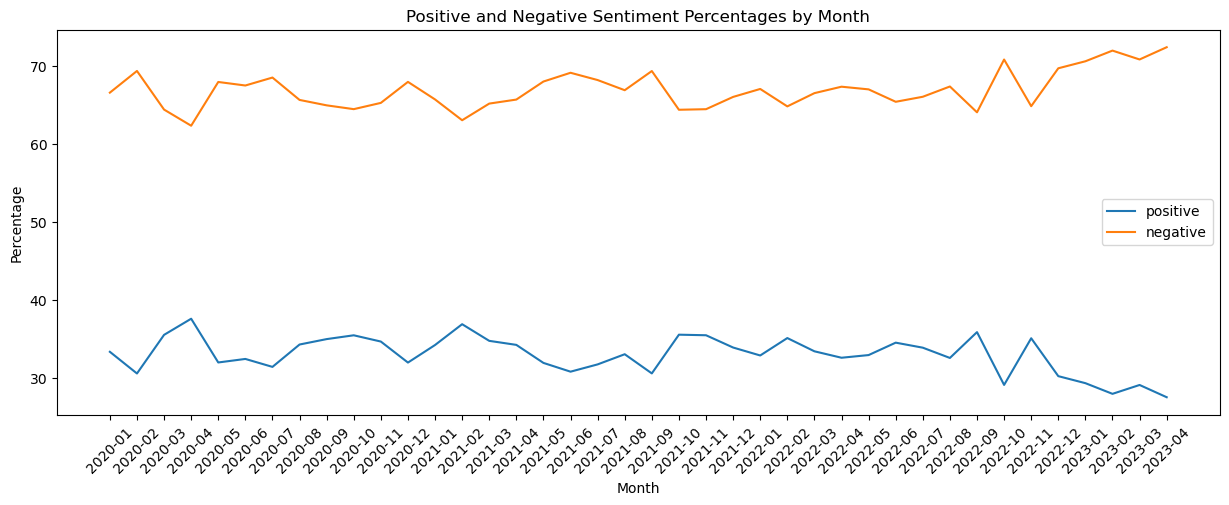

In [48]:
import matplotlib.pyplot as plt

# Add columns 'positive' and 'negative' to df_sentences_sentiment
df_sentences_sentiment['positive'] = df_sentences_sentiment['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df_sentences_sentiment['negative'] = df_sentences_sentiment['sentiment'].apply(lambda x: 1 if x == 'negative' else 0)

# Convert 'date' column to datetime format
df_sentences_sentiment['date'] = pd.to_datetime(df_sentences_sentiment['date'])

# Create a new column for the month
df_sentences_sentiment['month'] = df_sentences_sentiment['date'].dt.to_period('M')

# Group by month and calculate the total count
df_month_total = df_sentences_sentiment.groupby('month').size().reset_index(name='total')

# Group by month and sum the positive and negative
df_month_sentiment = df_sentences_sentiment.groupby('month')['positive', 'negative'].sum().reset_index()

# Merge the two dataframes
df_sentences_sentiment_grouped = df_month_sentiment.merge(df_month_total, on='month')

# Calculate the positive and negative percentages
df_sentences_sentiment_grouped['positive_percentage'] = df_sentences_sentiment_grouped['positive'] / df_sentences_sentiment_grouped['total'] * 100
df_sentences_sentiment_grouped['negative_percentage'] = df_sentences_sentiment_grouped['negative'] / df_sentences_sentiment_grouped['total'] * 100

# Convert the month column to string format
df_sentences_sentiment_grouped['month'] = df_sentences_sentiment_grouped['month'].astype(str)

# Convert the month column to pandas categorical for proper sorting
df_sentences_sentiment_grouped['month'] = pd.Categorical(df_sentences_sentiment_grouped['month'], categories=df_sentences_sentiment_grouped['month'], ordered=True)

# Sort the dataframe by month
df_sentences_sentiment_grouped = df_sentences_sentiment_grouped.sort_values(by='month')

# Convert the month to numpy array
month = df_sentences_sentiment_grouped['month'].to_numpy()
# Convert the positive percentage to numpy array
positive_percentage = df_sentences_sentiment_grouped['positive_percentage'].to_numpy()
# Convert the negative percentage to numpy array
negative_percentage = df_sentences_sentiment_grouped['negative_percentage'].to_numpy()

# Create a line plot to show the positive and negative percentages by month
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(month, positive_percentage, label='positive')
ax.plot(month, negative_percentage, label='negative')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage')
ax.set_title('Positive and Negative Sentiment Percentages by Month')
ax.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


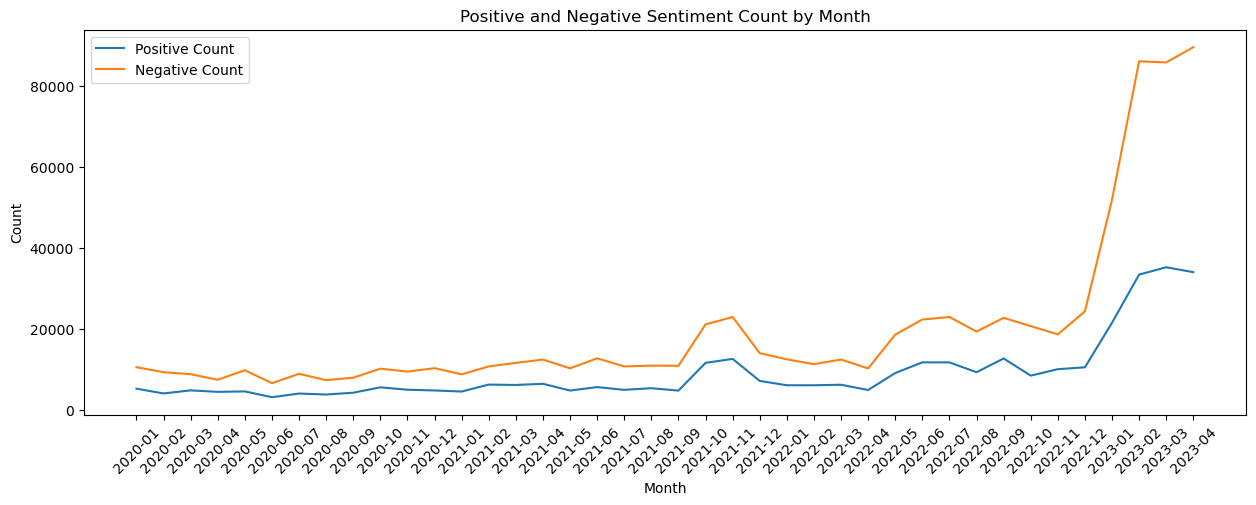

In [47]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime format
df_sentences_sentiment['date'] = pd.to_datetime(df_sentences_sentiment['date'])

# Create a new column for the month
df_sentences_sentiment['month'] = df_sentences_sentiment['date'].dt.to_period('M')

# Group by month and calculate the total count of positive and negative sentiment
df_month_sentiment = df_sentences_sentiment.groupby('month')['positive', 'negative'].sum().reset_index()

# Convert the month column to string format
df_month_sentiment['month'] = df_month_sentiment['month'].astype(str)

# Convert the month column to pandas categorical for proper sorting
df_month_sentiment['month'] = pd.Categorical(df_month_sentiment['month'], categories=df_month_sentiment['month'], ordered=True)

# Sort the dataframe by month
df_month_sentiment = df_month_sentiment.sort_values(by='month')

# Convert the month to numpy array
month = df_month_sentiment['month'].to_numpy()
# Convert the positive count to numpy array
positive_count = df_month_sentiment['positive'].to_numpy()
# Convert the negative count to numpy array
negative_count = df_month_sentiment['negative'].to_numpy()

# Create a line plot to show the count of positive and negative sentiment by month
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(month, positive_count, label='Positive Count')
ax.plot(month, negative_count, label='Negative Count')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Positive and Negative Sentiment Count by Month')
ax.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


#### Analyze top reasons for successful AI data science / AI initiatives (sentiment analysis) - these can be related to technology maturity, people, data availability, etc.

For Positive Sentences

In [10]:
df_positive = df_sentences_sentiment[df_sentences_sentiment['sentiment']=='positive']

In [11]:
df_positive.shape

(368337, 11)

In [18]:
# check the number of duplicates in sentence column
df_positive_clean = df_positive.copy()
df_positive_clean.drop_duplicates(subset=['sentence'], inplace=True)
df_positive_clean.shape

(212518, 11)

In [42]:
# !pip install bokeh --upgrade
# !pip install ktrain --upgrade

In [15]:
import bokeh

print('Bokeh Version: ' + bokeh.__version__)

Bokeh Version: 3.1.1


In [16]:
import ktrain

print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.37.0


In [29]:
texts = df_positive_clean['sentence'].tolist()
texts[:5]

['(People’s Daily Online,Thanks to the application of an artificial intelligence (AI)-empowered roadside electronic toll collection (ETC) system, China’s capital city Beijing has seen significant improvement in the efficiency of parking fee collection, turnover of roadside parking spots, order in roadside parking, as well as traffic congestion.',
 'Besides, it can resist the interference of extreme weather conditions like rain, snow, and fog, and form complete graphic evidence based on wheel path of vehicles.,Each set of cameras of the “AIpark Sky Eye” system can monitor multiple parking spots at the same time for 24 hours a day.',
 'Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek.,Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek,Forget ML, AI and Industry 4.0 – obsolescence should be your focus,The world entered a new era of accelerated t

In [30]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=20, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 4min 3s, sys: 159 ms, total: 4min 3s
Wall time: 4min 3s


In [31]:
tm.print_topics()

topic 0 | chatgpt new like content users art images tool text good
topic 1 | new said future tech big ceo best technologies space systems
topic 2 | companies models openai model able products large chatgpt year generative
topic 3 | learning machine best deep way make access algorithms language natural
topic 4 | digital security smart computing right platforms home voice virtual point
topic 5 | market intelligence artificial global analysis growth report forecast key industry
topic 6 | years training internet come continue like patient days perfect chat
topic 7 | news video product latest million play series launch game com
topic 8 | data process time better understanding drug helps development project information
topic 9 | chatbot build questions says set comes privacy job highly work
topic 10 | recognition important using features study health ensure ai-based teams care
topic 11 | intelligence artificial human china america europe humans south africa north
topic 12 | use people power 

#### For Negative Sentences

In [10]:
df_negative = df_sentences[df_sentences['sentiment']=='negative']
df_negative.drop_duplicates(subset=['sentence'], inplace=True)
df_negative.shape

(465374, 8)

In [12]:
texts_neg = df_negative['sentence'].tolist()
texts_neg[:5]

[',With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they drive away.,“This road used to be full of cars, and even the normal lanes were occupied.',
 'With all the cars being parked in designated parking spots on the roadside, the road now seems brighter and wider,” Wang said.,The smart roadside ETC system “AIpark Sky Eye” adopted by Beijing is developed, operated, and maintained by AIpark, a Beijing-based leading smart parking solution provider.,The company’s intelligent system has brought into full play the advantages of AI technologies and effectively addressed the shortage of parking spaces and the problem of irregular parking in cities.',
 'The system has therefore been listed among the country’s innovation projects that integrate AI deeply into the real economy in 2018 by China’s Ministry of Industry and Information Technology (MIIT).,Traditional parking management equi

In [17]:
%%time
tm_neg = ktrain.text.get_topic_model(
    texts=texts_neg, 
    n_topics=20, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 7min 31s, sys: 380 ms, total: 7min 32s
Wall time: 7min 32s


In [18]:
tm_neg.print_topics()

topic 0 | companies customer services products service uses financial video amazon develop
topic 1 | provide conversational india marketing learn facebook like state virtual tasks
topic 2 | news today health announced new content updated platform leader minutes
topic 3 | google microsoft tech search openai new said bing technology bard
topic 4 | chatgpt openai like tools users tool used chatbot researchers text
topic 5 | time just power access edge making nvidia computing days performance
topic 6 | data information security models language generative applications privacy read processing
topic 7 | research development including improve medical support advanced healthcare help systems
topic 8 | technology world need public science government china innovation solution change
topic 9 | use says systems ceo said image musk open set national
topic 10 | make year way people law does jobs said work cases
topic 11 | intelligence artificial global market ibm billion adoption technologies corpora

From above, we can know top reasons for AI success or fail are, and the timeline plot of sentiment


### Sentiment By NER

In [ ]:
# read the csv file sentences_sentiment.csv
df_sentences_sentiment = pd.read_parquet('df_sentences_sentiment.parquet')


In [3]:
%%time

import multiprocessing

def process_sentence(sentiments):
    entities = []
    labels = []
    positive_count = []
    negative_count = []

    for text, sentiment in sentiments:
        doc = nlp(text)
        for ent in doc.ents:
            entities.append(ent.text)
            labels.append(ent.label_)
            if sentiment == 'positive':
                positive_count.append(1)
                negative_count.append(0)
            elif sentiment == 'negative':
                positive_count.append(0)
                negative_count.append(1)

    return entities, labels, positive_count, negative_count

# Split the input DataFrame into chunks for multiprocessing
chunks = np.array_split(df_sentences_sentiment[['sentence', 'sentiment']].values, multiprocessing.cpu_count())

# Create a multiprocessing Pool
pool = multiprocessing.Pool()

# Apply the process_sentence function to each chunk in parallel
results = pool.map(process_sentence, chunks)

# Combine the results from all processes
entities = []
labels = []
positive_count = []
negative_count = []

for result in results:
    entities.extend(result[0])
    labels.extend(result[1])
    positive_count.extend(result[2])
    negative_count.extend(result[3])

# Create a DataFrame of entities, labels, positive count, and negative count
df_entities = pd.DataFrame({'Entities': entities, 'Labels': labels, 'Positive Count': positive_count, 'Negative Count': negative_count})

# Group by entities and labels, and sum the positive and negative counts
df_entities_grouped = df_entities.groupby(['Entities', 'Labels']).agg({'Positive Count': 'sum', 'Negative Count': 'sum'}).reset_index()

# Sort the DataFrame by positive count in descending order
df_entities_grouped = df_entities_grouped.sort_values(by='Positive Count', ascending=False)

# Display the top 20 entities with labels, positive and negative counts
top_entities = df_entities_grouped.head(20)
top_entities


CPU times: user 6.22 s, sys: 1.06 s, total: 7.27 s
Wall time: 43min 51s


,Entities,Labels,Positive Count,Negative Count
71404,AI,PRODUCT,147484,283716
71402,AI,ORG,72899,160249
144866,ChatGPT,ORG,32980,98020
108130,Artificial Intelligence,ORG,15903,15777
455904,first,ORDINAL,13947,26958
294731,Microsoft,ORG,12695,35047
218408,Google,ORG,12612,39933
71397,AI,FAC,12153,23002
322188,OpenAI,ORG,10312,35798
413650,US,GPE,9841,9714


In [7]:
df_entities_grouped.to_parquet('df_entities_grouped.parquet')
df_entities_grouped = pd.read_parquet('df_entities_grouped.parquet')

In [35]:
# Filter entities for 'ORD'
df_entities_ord = df_entities_grouped[df_entities_grouped['Labels'] == 'ORG'].head(20)
df_entities_ord['Total_Frequency'] = df_entities_ord['Positive Count'] + df_entities_ord['Negative Count']
df_entities_ord = df_entities_ord[['Entities', 'Total_Frequency']]

# Filter entities for 'GPE'
df_entities_gpe = df_entities_grouped[df_entities_grouped['Labels'] == 'GPE'].head(20)
df_entities_gpe['Total_Frequency'] = df_entities_gpe['Positive Count'] + df_entities_gpe['Negative Count']
df_entities_gpe = df_entities_gpe[['Entities', 'Total_Frequency']]

# Filter entities for 'PERSON'
df_entities_person = df_entities_grouped[df_entities_grouped['Labels'] == 'PERSON'].head(20)
df_entities_person['Total_Frequency'] = df_entities_person['Positive Count'] + df_entities_person['Negative Count']
df_entities_person = df_entities_person[['Entities', 'Total_Frequency']]

# Print the most frequent entities for 'ORD'
print("                Most frequent ORG entities:\n")
print(df_entities_ord)

# Print the most frequent entities for 'GPE'
print("\n           Most frequent GPE entities:\n")
print(df_entities_gpe)

# Print the most frequent entities for 'PERSON'
print("\n           Most frequent PERSON entities:\n")
print(df_entities_person)


                Most frequent ORG entities:

                              Entities  Total_Frequency
71402                               AI           233148
144866                         ChatGPT           131000
108130         Artificial Intelligence            31680
294731                       Microsoft            47742
218408                          Google            52545
322188                          OpenAI            46110
235307                             IBM            15673
278723                              ML            14993
305418                          NVIDIA            11191
481156     the Artificial Intelligence             7748
244119                           Intel             6822
103983                           Apple             6336
280530                Machine Learning             6167
118890                           Baidu             6090
207575                           GPT-3             7490
214029  Global Artificial Intelligence             3877
195

In [14]:
# Display the top 20 entities with labels, positive and negative counts
top_entities = df_entities_grouped.head(20)
top_entities
# Filter entities for 'ORD'
df_entities_ord = top_entities[top_entities['Labels'] == 'ORG']
print(f'The most frequent ORG entities are:\n{df_entities_ord["Entities"].values}')

# Filter entities for 'GPE'
df_entities_gpe = top_entities[top_entities['Labels'] == 'GPE']
print(f'The most frequent GPE entities are:\n{df_entities_gpe["Entities"].values}')

# Filter entities for 'PERSON'
df_entities_person = top_entities[top_entities['Labels'] == 'PERSON']
print(f'The most frequent PERSON entities are:\n{df_entities_person["Entities"].values}')


The most frequent ORG entities are:
['AI' 'ChatGPT' 'Artificial Intelligence' 'Microsoft' 'Google' 'OpenAI'
 'IBM' 'ML']
The most frequent GPE entities are:
['US' 'China' 'India']
The most frequent PERSON entities are:
[]


In [2]:
import pandas as pd
df_entities_grouped = pd.read_parquet('df_entities_grouped.parquet')

# print the top 10 positive count entities where label is ORG
df_entities_grouped[(df_entities_grouped['Labels']=='ORG') & (df_entities_grouped['Positive Count']>0)].head(10)


,Entities,Labels,Positive Count,Negative Count
71402,AI,ORG,72899,160249
144866,ChatGPT,ORG,32980,98020
108130,Artificial Intelligence,ORG,15903,15777
294731,Microsoft,ORG,12695,35047
218408,Google,ORG,12612,39933
322188,OpenAI,ORG,10312,35798
235307,IBM,ORG,6579,9094
278723,ML,ORG,5643,9350
305418,NVIDIA,ORG,4444,6747
481156,the Artificial Intelligence,ORG,3495,4253


In [6]:
df_entities_grouped[(df_entities_grouped['Labels']=='GPE')& (df_entities_grouped['Positive Count']>0)].head(10)


,Entities,Labels,Positive Count,Negative Count
413650,US,GPE,9841,9714
147326,China,GPE,6571,11096
240298,India,GPE,6141,8976
412020,U.S.,GPE,3779,9460
250832,Japan,GPE,3309,1612
139674,Canada,GPE,3015,2861
412930,UK,GPE,2630,5161
203607,France,GPE,2304,1844
326862,PRNewswire,GPE,2147,3910
211743,Germany,GPE,2024,1847


In [4]:
df_entities_grouped[(df_entities_grouped['Labels']=='PERSON') & (df_entities_grouped['Positive Count']>0)].head(10)


,Entities,Labels,Positive Count,Negative Count
207720,GPT-4,PERSON,2934,7497
125081,Bing,PERSON,1614,3229
302415,Musk,PERSON,1281,5707
187271,Elon Musk,PERSON,1280,4630
361775,Sam Altman,PERSON,1055,1975
373912,Size,PERSON,993,264
224812,Hailo,PERSON,617,852
247920,JAIC,PERSON,609,951
377899,Sophy,PERSON,503,249
124061,Biden,PERSON,455,2206


In [8]:
df_entities_grouped.shape

(509713, 4)

In [9]:
df_entities_grouped['Percentage of Positive Count'] = df_entities_grouped['Positive Count']/(df_entities_grouped['Positive Count']+df_entities_grouped['Negative Count'])

In [13]:
df_entities_grouped_clean = df_entities_grouped[(df_entities_grouped['Positive Count'] >= 20) & (df_entities_grouped['Negative Count'] >= 20)]
df_entities_grouped_clean = df_entities_grouped_clean.sort_values(by='Percentage of Positive Count', ascending=False)
df_entities_grouped_clean

,Entities,Labels,Positive Count,Negative Count,Percentage of Positive Count
84472,AIB,ORG,307,25,0.924699
224316,HSS,ORG,238,20,0.922481
262292,Key Players,ORG,394,42,0.903670
42791,"2026,Global",CARDINAL,213,26,0.891213
183104,EXAONE,PERSON,265,36,0.880399
...,...,...,...,...,...
203456,Fox News,ORG,26,447,0.054968
85254,AIO,ORG,71,1351,0.049930
283053,Managed Distribution Plan,LAW,20,448,0.042735
410537,"Tuesday, March 21, 2023",DATE,22,662,0.032164


In [14]:
# find the entities where label is ORG
df_entities_grouped_ORG = df_entities_grouped_clean[df_entities_grouped_clean['Labels'] == 'ORG']
# find the entities where label is PERSON
df_entities_grouped_PERSON = df_entities_grouped_clean[df_entities_grouped_clean['Labels'] == 'PERSON']
# find the entities where label is GPE
df_entities_grouped_GPE = df_entities_grouped_clean[df_entities_grouped_clean['Labels'] == 'GPE']

In [15]:
df_entities_grouped_ORG.head(10)

,Entities,Labels,Positive Count,Negative Count,Percentage of Positive Count
84472,AIB,ORG,307,25,0.924699
224316,HSS,ORG,238,20,0.922481
262292,Key Players,ORG,394,42,0.903670
259016,KSU,ORG,252,39,0.865979
439817,Zimmer Biomet,ORG,140,23,0.858896
234141,Humane,ORG,606,102,0.855932
280193,MWC,ORG,367,64,0.851508
227678,Healthcare Market Size,ORG,104,20,0.838710
243563,Institut Curie,ORG,161,32,0.834197
338379,Prisma Labs,ORG,173,37,0.823810


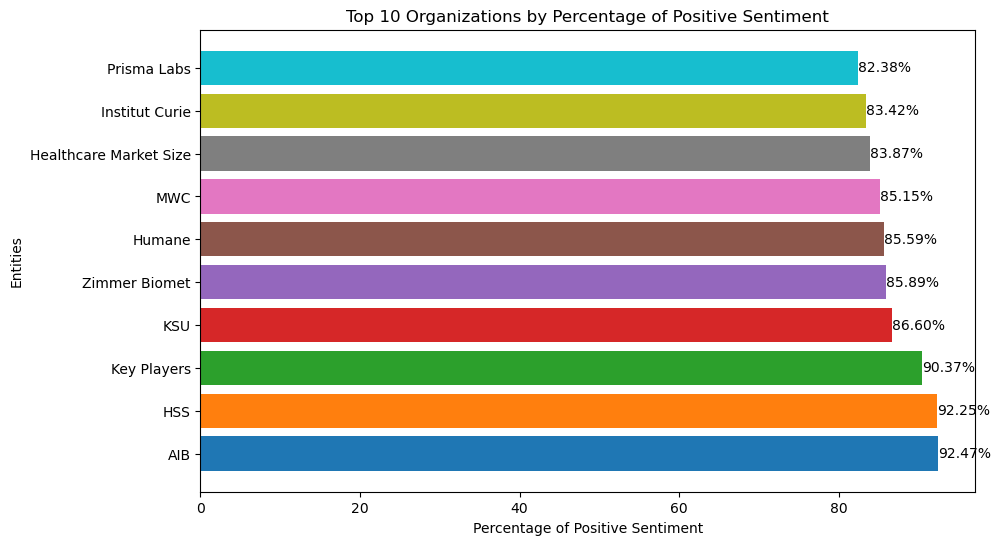

In [27]:
import matplotlib.pyplot as plt

# Sort the DataFrame by Percentage of Positive Count in descending order and select the top 10
top_10_entities = df_entities_grouped_ORG.nlargest(10, 'Percentage of Positive Count')

# Generate a list of colors for each entity
colors = plt.cm.tab10(range(len(top_10_entities)))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_entities['Entities'], top_10_entities['Percentage of Positive Count']*100, color=colors)

# Customizing the plot
plt.title('Top 10 Organizations by Percentage of Positive Sentiment')
plt.xlabel('Percentage of Positive Sentiment')
plt.ylabel('Entities')

# Add labels for each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

# Display the plot
plt.show()


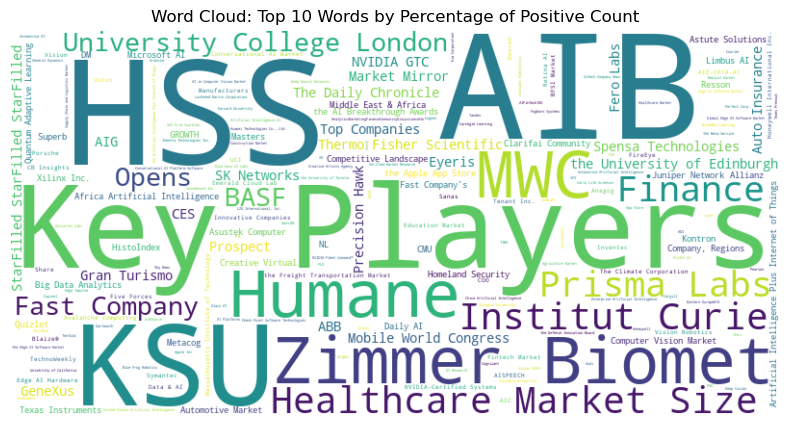

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming df_entities_grouped_GPE is the DataFrame containing the relevant data

# Sort the DataFrame by the "Percentage of Positive Count" column in descending order
df_sorted = df_entities_grouped_ORG.sort_values('Percentage of Positive Count', ascending=False)

# Concatenate the text from the 'word' column based on the sorted order
word_frequency = {row['Entities']: row['Percentage of Positive Count'] for _, row in df_sorted.iterrows()}
word_text = ' '.join([word for word in word_frequency.keys()])

# Generate the word cloud with word frequencies as weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)

# Create the plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Top 10 Words by Percentage of Positive Count')
plt.show()

In [17]:
df_entities_grouped_PERSON.head(10)

,Entities,Labels,Positive Count,Negative Count,Percentage of Positive Count
183104,EXAONE,PERSON,265,36,0.880399
378952,SpaceX,PERSON,243,34,0.877256
288847,Max,PERSON,155,24,0.865922
199572,Finn,PERSON,177,31,0.850962
200040,Firmenich,PERSON,225,45,0.833333
262094,Kevin Smith,PERSON,119,24,0.832168
249394,James Coomer,PERSON,116,26,0.816901
140599,Cara,PERSON,106,26,0.803030
252736,Jetson AGX Xavier,PERSON,84,21,0.800000
87860,ASIG_AIGC,PERSON,123,32,0.793548


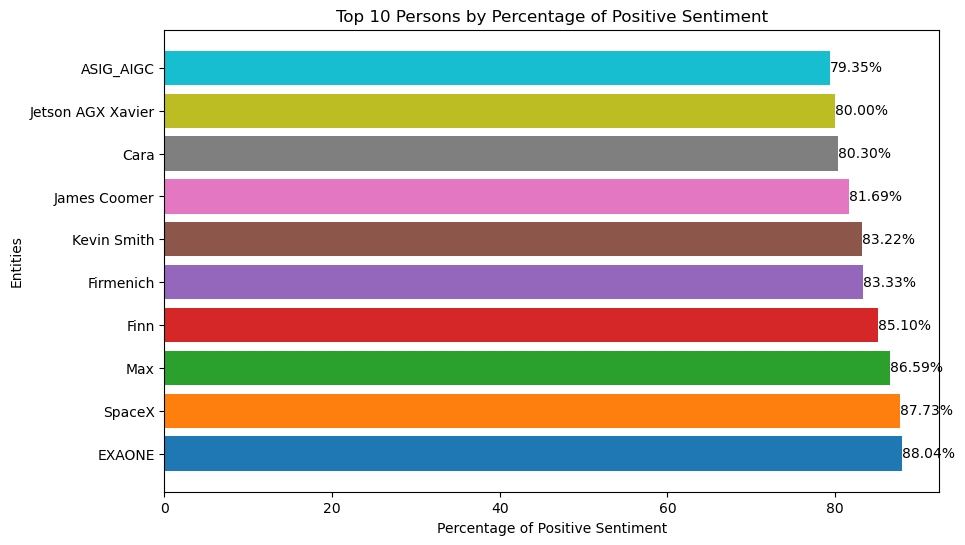

In [26]:
import matplotlib.pyplot as plt

# Sort the DataFrame by Percentage of Positive Count in descending order and select the top 10
top_10_entities = df_entities_grouped_PERSON.nlargest(10, 'Percentage of Positive Count')

# Generate a list of colors for each entity
colors = plt.cm.tab10(range(len(top_10_entities)))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_entities['Entities'], top_10_entities['Percentage of Positive Count']*100, color=colors)

# Customizing the plot
plt.title('Top 10 Persons by Percentage of Positive Sentiment')
plt.xlabel('Percentage of Positive Sentiment')
plt.ylabel('Entities')

# Add labels for each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

# Display the plot
plt.show()


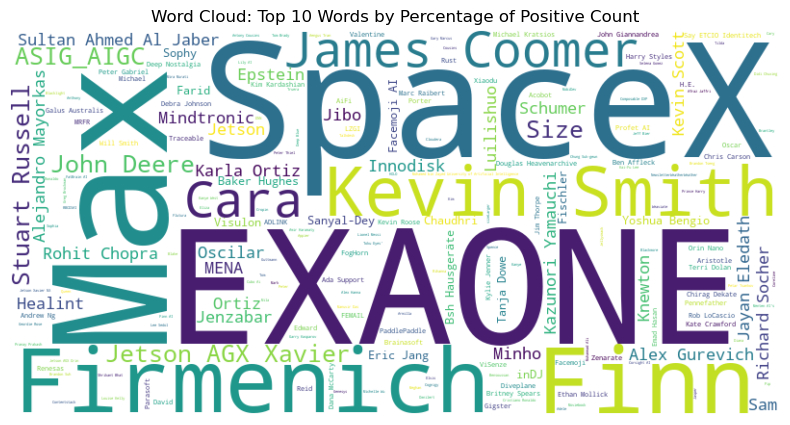

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming df_entities_grouped_GPE is the DataFrame containing the relevant data

# Sort the DataFrame by the "Percentage of Positive Count" column in descending order
df_sorted = df_entities_grouped_PERSON.sort_values('Percentage of Positive Count', ascending=False)

# Concatenate the text from the 'word' column based on the sorted order
word_frequency = {row['Entities']: row['Percentage of Positive Count'] for _, row in df_sorted.iterrows()}
word_text = ' '.join([word for word in word_frequency.keys()])

# Generate the word cloud with word frequencies as weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)

# Create the plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Top 10 Words by Percentage of Positive Count')
plt.show()

In [18]:
df_entities_grouped_GPE.head(10)

,Entities,Labels,Positive Count,Negative Count,Percentage of Positive Count
246959,Irvine,GPE,173,33,0.839806
132413,Bulgaria,GPE,107,22,0.829457
206481,GCC,GPE,189,47,0.800847
106631,Argentina,GPE,508,128,0.798742
288835,Mavrx,GPE,92,26,0.779661
153241,Columbia,GPE,90,26,0.775862
332766,Phoenix,GPE,121,35,0.775641
147256,Chile,GPE,168,52,0.763636
113556,Austria,GPE,128,46,0.735632
185858,Egypt,GPE,655,238,0.733483


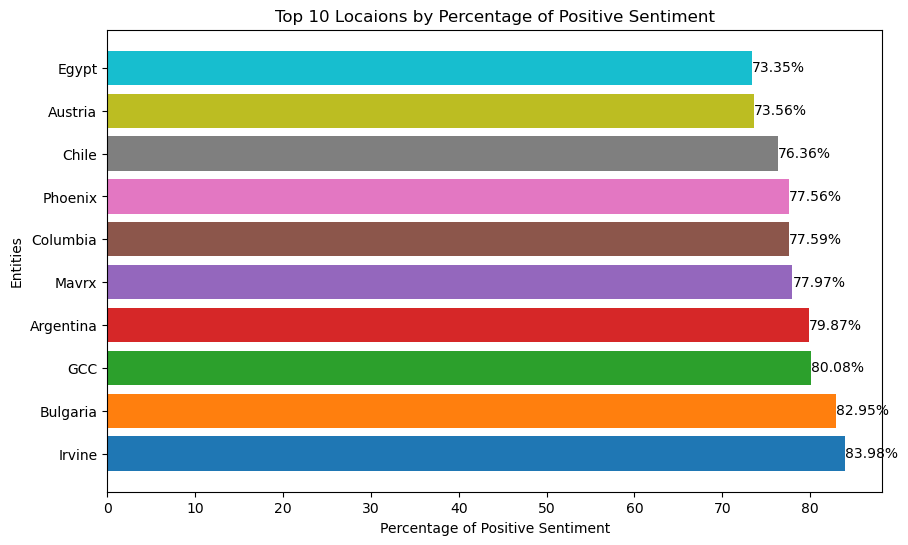

In [25]:
import matplotlib.pyplot as plt

# Sort the DataFrame by Percentage of Positive Count in descending order and select the top 10
top_10_entities = df_entities_grouped_GPE.nlargest(10, 'Percentage of Positive Count')

# Generate a list of colors for each entity
colors = plt.cm.tab10(range(len(top_10_entities)))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_entities['Entities'], top_10_entities['Percentage of Positive Count']*100, color=colors)

# Customizing the plot
plt.title('Top 10 Locaions by Percentage of Positive Sentiment')
plt.xlabel('Percentage of Positive Sentiment')
plt.ylabel('Entities')

# Add labels for each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

# Display the plot
plt.show()


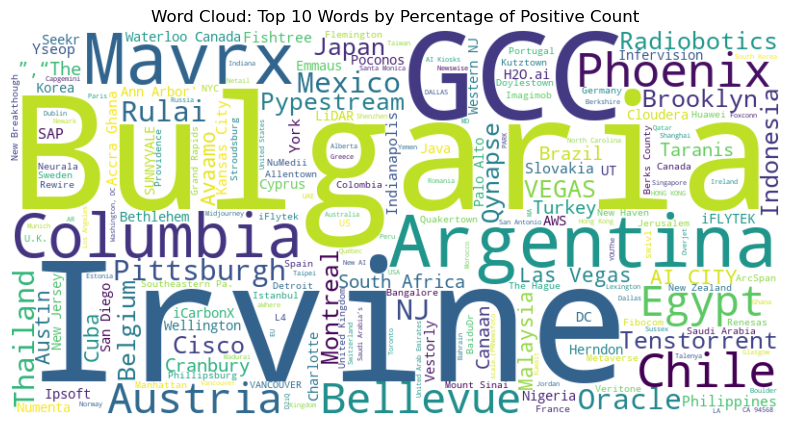

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming df_entities_grouped_GPE is the DataFrame containing the relevant data

# Sort the DataFrame by the "Percentage of Positive Count" column in descending order
df_sorted = df_entities_grouped_GPE.sort_values('Percentage of Positive Count', ascending=False)

# Concatenate the text from the 'word' column based on the sorted order
word_frequency = {row['Entities']: row['Percentage of Positive Count'] for _, row in df_sorted.iterrows()}
word_text = ' '.join([word for word in word_frequency.keys()])

# Generate the word cloud with word frequencies as weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)

# Create the plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Top 10 Words by Percentage of Positive Count')
plt.show()


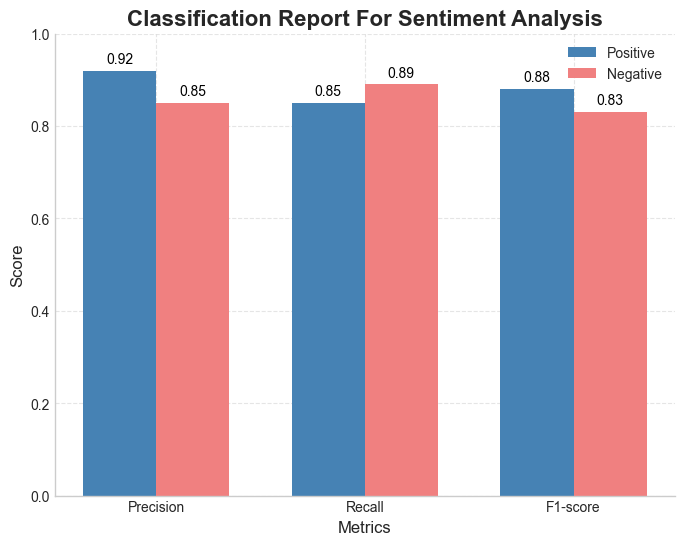

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# This is manually labelled thorugh the sentiment analysis result

# Define precision, recall, and F1-score for positive and negative classes
positive_precision = 0.92
positive_recall = 0.85
positive_f1 = 0.88

negative_precision = 0.85
negative_recall = 0.89
negative_f1 = 0.83

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('seaborn-whitegrid')

# Create labels and positions for the bars
labels = ['Precision', 'Recall', 'F1-score']
positive_vals = [positive_precision, positive_recall, positive_f1]
negative_vals = [negative_precision, negative_recall, negative_f1]
x = np.arange(len(labels))

# Define bar width
bar_width = 0.35

# Plot the bars for positive and negative classes
ax.bar(x - bar_width/2, positive_vals, width=bar_width, color='steelblue', label='Positive')
ax.bar(x + bar_width/2, negative_vals, width=bar_width, color='lightcoral', label='Negative')

# Add values on top of each bar
for i, val in enumerate(positive_vals):
    ax.text(i - bar_width/2, val + 0.01, f'{val:.2f}', ha='center', va='bottom', color='black')
for i, val in enumerate(negative_vals):
    ax.text(i + bar_width/2, val + 0.01, f'{val:.2f}', ha='center', va='bottom', color='black')

# Set plot title and labels
ax.set_title('Classification Report For Sentiment Analysis', fontsize=16, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)

# Set x-axis tick labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Set y-axis limits
ax.set_ylim([0, 1])

# Add legend
ax.legend()

# Add grid lines and remove spines
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()
